## Projekt: Rekonstrukcja kinematyki rozpadu Higgs → ττ za pomocą sieci neuronowej

### **Autor:** Jakub Kuśmierski  
### **Data:** 23.04.2025  
### **Opis:**   
Celem projektu jest stworzenie modelu regresyjnego o architekturze Fully Connected Neural Network (FCNN), którego zadaniem jest rekonstrukcja parametrów kinematycznych bozonu Higgsa oraz cząstek τ na podstawie danych symulacyjnych. 

Zazwyczaj problem wynika z faktu, że w rozpadzie taonów nie obserwujemy neutrin, które wynoszą ze zdarzenia część energii i pędu. Ich odtworzenie jest trudne w środowisku maszyny hadronowej, a MET (Missing Transverse Energy), który zawiera ich wkład, jest odtwarzany z dużą niedokładnością.

Model będzie oceniany poprzez porównanie jego wyników z obecnie stosowanym narzędziem referencyjnym fastMTT.

### Diagram Feynmana dla procesu Higgs → ττ

![Diagram Feynmanna dla procesu $H -> \tau \tau $](https://www.researchgate.net/publication/303921835/figure/fig2/AS:651132598751241@1532253517741/Feynman-diagram-describing-the-decay-H-t-t-with-one-t-subsequently-decaying.png)

## Definicja danych wejściowych i wyjściowych

### Dane wejściowe (cechy modelu)

- `dm1`, `dm2` – różnica masy (delta mass) w rozpadzie τ1 i τ2  
- `pt1`, `pt2` – pęd poprzeczny pierwszego i drugiego produktu rozpadu τ  
- `eta1`, `eta2` – pseudopospółrzędna η pierwszego i drugiego produktu  
- `phi1`, `phi2` – azymut pierwszego i drugiego produktu  
- `mass1`, `mass2` – masa widzialna produktów rozpadu (może to być np. układ hadronowy)  
- `trueMETx`, `trueMETy` – wygenerowane wartości brakującej energii poprzecznej (MET), komponenty w kierunkach x i y  
- `var_xx`, `var_yy` – wariancje niepewności MET w kierunkach x i y  
- `cov_xy` – kowariancja między komponentami x i y MET

###  Dane wyjściowe (predykcje modelu)

####  Kinematyka bozonu Higgsa:
- `H_m` – masa bozonu Higgsa  
- `H_pt` – pęd poprzeczny Higgsa  
- `H_eta` – pseudopospieszność η bozonu Higgsa  
- `H_phi` – azymut φ bozonu Higgsa  

####  Kinematyka cząstki τ1:
- `tau1_m` – masa cząstki τ1  
- `tau1_pt` – pęd poprzeczny τ1  
- `tau1_eta` – pseudopospieszność τ1  
- `tau1_phi` – azymut τ1  

####  Kinematyka cząstki τ2:
- `tau2_m` – masa cząstki τ2  
- `tau2_pt` – pęd poprzeczny τ2  
- `tau2_eta` – pseudopospspieszność τ2  
- `tau2_phi` – azymut τ2


Kinematyka τ1 i τ2, jeśli uda się wykonać, w głównej mierze chce skupić pracę na początek na kinmatyce bozonu Higgsa i dopiero później nad taonami.

**Uwaga dotycząca danych MET:**  
W projekcie planowane jest dodatkowe przetwarzanie danych MET (`trueMETx`, `trueMETy`), polegające na ich rozmyciu zgodnie z rozkładem normalnym (Gaussa), w celu zasymulowania realizmu rekonstrukcji eksperymentalnej. Rozkład ten może mieć zmienną wariancję dla każdej próbki, co pozwoli zwiększyć odporność modelu na przeuczenie względem statystyki MET oraz lepiej odzwierciedli warunki rzeczywistych eksperymentów hadronowych. Takie podejście ma na celu przygotowanie sieci do bardziej uniwersalnego działania w warunkach różnych rozrzutów niepewności.



## Lokalizacja danych

Dane do projektu znajdują się na scratch_cmsse, naleącym do doktoranta Wiktora Matyszkiewicza z Wydaiłu Fizyki Uniwersytetu Warszawskiego.

```Python
    data_path = "/home/wmatyszk/scratch_cmsse/wmatyszk/project_sieci/csv/"
```

## Przewidywana architektura modelu

Model zastosowany w projekcie będzie oparty na architekturze **Fully Connected Neural Network (FCNN)**. Jego zadaniem będzie predykcja ciągłych parametrów kinematycznych bozonu Higgsa oraz cząstek τ, bazując na danych symulacyjnych z rekonstrukcją MET i obserwowanych produktach rozpadu.

#### **Etap bazowy – klasyczny FCNN**
Na pierwszym etapie projekt zakłada zastosowanie pojedynczej, w pełni połączonej sieci neuronowej o następującej strukturze:
- **Wejście:** wektor złożony z obserwowalnych parametrów rozpadu (pędy poprzeczne, kąty, masy, MET oraz jego wariancje i kowariancja)
- **Część ukryta:** kilka warstw Dense z funkcją aktywacji ReLU i regularizacją (np. Dropout), których liczba i szerokość zostaną ustalone eksperymentalnie
- **Wyjście:** 12-wymiarowy wektor z wartościami kinematycznymi Higgsa i obu taonów (masa, pT, eta, phi dla każdej z trzech cząstek)

Model ten będzie uczył się funkcji odwzorowującej dane wejściowe na pełną rekonstrukcję rozpadu Higgs → τ⁺τ⁻, przy czym trening będzie nadzorowany i oparty na rzeczywistych wartościach wygenerowanych w symulacji.

#### **Etap rozszerzony – architektura dwugałęziowa**
Na późniejszym etapie rozważone zostanie wdrożenie **dwugałęziowej architektury FCNN**, w której:
- **Gałąź pierwsza** przetwarza informacje dotyczące **rozpadu taonów** (parametry masy, pędu, kąta i masy produktów)
- **Gałąź druga** przetwarza parametry związane z **MET** (trueMETx, trueMETy, wariancje, kowariancja)
- Po przetworzeniu każdej z gałęzi, ich reprezentacje będą **łączone (concatenate)** i dalej przetwarzane w wspólnej części modelu w celu dokonania końcowej predykcji

Celem takiego rozwiązania jest umożliwienie modelowi osobnej specjalizacji w dwóch fizycznie różnych typach informacji – jednej związanej z widzialnymi cząstkami, drugiej z efektem nieobserwowalnych neutrin.

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np
import pandas as pd
import ast
import glob
import functools

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

import importlib
import sys
sys.path.append("/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Wstępne wczytanie danych 

In [2]:
df = pd.read_csv('/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/data/sieci/Higgs100-100.csv')
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,tau.pt,tau.eta,tau.phi,H.pt,...,eta1,phi1,mass1,type1,dm2,pt2,eta2,phi2,mass2,type2
0,112.93847,492.961600,1.77682,258.983430,1.77682,233.978200,"[92.95304, 46.2441]","[1.683909, 2.3044999]","[-1.6908998, 2.7341945]","[91.338554, 91.338554]",...,1.684577,-1.702712,0.105658,-1,1,24.717950,2.375069,2.698482,3.664079,-1
1,136.14160,233.098040,1.77682,197.310800,1.77682,35.787228,"[43.819786, 35.51084]","[-2.1852353, 0.11430719]","[1.2113028, -1.5094808]","[18.45391, 18.45391]",...,-2.211803,1.229569,0.105658,-1,1,34.640102,0.116949,-1.524274,3.590217,-1
2,79.42800,111.873474,1.77682,58.120876,1.77682,53.752600,"[27.620544, 53.61327]","[-1.374633, 0.064034745]","[0.0154061, 1.4857656]","[62.72349, 62.72349]",...,-1.348558,0.030219,0.105658,-1,1,41.771297,0.057130,1.466085,0.150325,-1
3,146.46970,429.625700,1.77682,112.535440,1.77682,317.090270,"[64.515366, 89.02436]","[1.1546935, 1.9430921]","[2.5013797, -1.6417618]","[76.78647, 76.78647]",...,1.162106,2.497047,0.000511,-1,3,22.375510,1.941621,-1.618577,0.105658,-1
4,99.35882,103.298640,1.77682,39.748230,1.77682,63.550407,"[39.36661, 57.967106]","[-0.1316975, 0.43450052]","[0.924177, -2.311872]","[19.139568, 19.139568]",...,-0.135670,1.012588,7.861639,-1,1,41.640660,0.426829,-2.313684,1.462912,-1


In [3]:
print(colored("Columns in the dataset:\n", 'green'), df.columns.values)

Columns in the dataset:
 ['H.m' 'H.E' 't1.m' 't1.E' 't2.m' 't2.E' 'tau.pt' 'tau.eta' 'tau.phi'
 'H.pt' 'H.eta' 'H.phi' 'METx' 'METy' 'trueMETx' 'trueMETy' 'dm1' 'pt1'
 'eta1' 'phi1' 'mass1' 'type1' 'dm2' 'pt2' 'eta2' 'phi2' 'mass2' 'type2']


Z pierwszego oglądu danych można zauważyć dwie rzeczy:
1. Dane dotyczące kinematyki tau: tau.pt, tau.eta, tau.phi — są zapisane w postaci [x, y] gdzie x oznacza wartość dla pierwszego tau, a y dla drugiego i należy je rozdzielić w dwie oddzielne kolumny
2. Dane kinematyki dotyczące Higgsa: H.pt, H.eta, H.phi — także są zapisane w podobnej postaci [x, x] gdzie wartość dla bozonu Higgsa jest podwojona więc trzeba usunąć drugą z nich

In [4]:
df['tau.pt'] = df['tau.pt'].apply(ast.literal_eval)
df['tau.eta'] = df['tau.eta'].apply(ast.literal_eval)
df['tau.phi'] = df['tau.phi'].apply(ast.literal_eval)
df['H.pt'] = df['H.pt'].apply(ast.literal_eval)
df['H.eta'] = df['H.eta'].apply(ast.literal_eval)
df['H.phi'] = df['H.phi'].apply(ast.literal_eval)

In [5]:
df['tau1_pt'] = df['tau.pt'].apply(lambda x: x[0])
df['tau2_pt'] = df['tau.pt'].apply(lambda x: x[1])

df['tau1_eta'] = df['tau.eta'].apply(lambda x: x[0])
df['tau2_eta'] = df['tau.eta'].apply(lambda x: x[1])

df['tau1_phi'] = df['tau.phi'].apply(lambda x: x[0])
df['tau2_phi'] = df['tau.phi'].apply(lambda x: x[1])


df['H_pt'] = df['H.pt'].apply(lambda x: x[0])
df['H_eta'] = df['H.eta'].apply(lambda x: x[0])
df['H_phi'] = df['H.phi'].apply(lambda x: x[0])

In [6]:
df.drop(columns=['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi'], inplace=True)
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,METx,METy,trueMETx,trueMETy,...,type2,tau1_pt,tau2_pt,tau1_eta,tau2_eta,tau1_phi,tau2_phi,H_pt,H_eta,H_phi
0,112.93847,492.961600,1.77682,258.983430,1.77682,233.978200,-21.783560,-16.464653,-28.096622,-33.670624,...,-1,92.953040,46.244100,1.683909,2.304500,-1.690900,2.734195,91.338554,2.342864,-2.197883
1,136.14160,233.098040,1.77682,197.310800,1.77682,35.787228,13.523408,10.390549,10.931591,18.558040,...,-1,43.819786,35.510840,-2.185235,0.114307,1.211303,-1.509481,18.453910,-3.018338,0.306871
2,79.42800,111.873474,1.77682,58.120876,1.77682,53.752600,19.325521,-0.114705,12.726479,15.444277,...,-1,27.620544,53.613270,-1.374633,0.064035,0.015406,1.485766,62.723490,-0.701157,1.032243
3,146.46970,429.625700,1.77682,112.535440,1.77682,317.090270,-18.230460,-65.446990,-18.597929,-55.965706,...,-1,64.515366,89.024360,1.154694,1.943092,2.501380,-1.641762,76.786470,2.344093,-2.427998
4,99.35882,103.298640,1.77682,39.748230,1.77682,63.550407,-9.357310,-19.005812,-1.084180,0.434001,...,-1,39.366610,57.967106,-0.131697,0.434501,0.924177,-2.311872,19.139568,0.940957,-2.507101


### Wczytanie wszystkich danych

Teraz należy wczytać dane ze wszystkich plików i zrobić dla nich to samo, co wcześniej zrobiono dla pierwszego pliku.

In [7]:
data_dir = '/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/data/sieci/'
csv_files = glob.glob(data_dir + "Higgs*.csv")

In [8]:
dfs = []

for file in csv_files:
    df = pd.read_csv(file)

    for col in ['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi']:
        df[col] = df[col].apply(ast.literal_eval)

    
    df['tau1_pt'] = df['tau.pt'].apply(lambda x: x[0])
    df['tau2_pt'] = df['tau.pt'].apply(lambda x: x[1])
    df['tau1_eta'] = df['tau.eta'].apply(lambda x: x[0])
    df['tau2_eta'] = df['tau.eta'].apply(lambda x: x[1])
    df['tau1_phi'] = df['tau.phi'].apply(lambda x: x[0])
    df['tau2_phi'] = df['tau.phi'].apply(lambda x: x[1])
    df['H_pt'] = df['H.pt'].apply(lambda x: x[0])
    df['H_eta'] = df['H.eta'].apply(lambda x: x[0])
    df['H_phi'] = df['H.phi'].apply(lambda x: x[0])

    df.drop(columns=['tau.pt', 'tau.eta', 'tau.phi', 'H.pt', 'H.eta', 'H.phi'], inplace=True)

    dfs.append(df)

I na koniec łączymy wszystkie data farme w jeden.

In [9]:
df = pd.concat(dfs, ignore_index=True)
df.head()

,H.m,H.E,t1.m,t1.E,t2.m,t2.E,METx,METy,trueMETx,trueMETy,...,type2,tau1_pt,tau2_pt,tau1_eta,tau2_eta,tau1_phi,tau2_phi,H_pt,H_eta,H_phi
0,196.73200,282.94920,1.77682,184.299360,1.77682,98.64985,-50.879560,-7.675525,-52.073196,-13.297127,...,-1,76.953780,98.63361,1.519704,-0.002149,-2.765061,1.797632,115.700005,1.164141,2.515362
1,170.96394,454.64020,1.77682,127.403140,1.77682,327.23706,236.432200,-97.585000,246.659970,-110.700200,...,-1,124.511536,228.12059,0.214641,0.901347,-0.984634,-0.233547,330.250270,0.726369,-0.493766
2,403.04907,770.57380,1.77682,453.754670,1.77682,316.81910,18.701082,-1.000554,14.325636,21.218117,...,-1,90.911680,252.49693,-2.290618,-0.699414,-2.556309,0.778071,164.195970,-2.063401,0.884353
3,218.99274,233.65942,1.77682,108.677956,1.77682,124.98147,-43.222538,-18.162619,-33.788174,-6.049116,...,-1,102.301540,117.20386,-0.350866,-0.362030,0.301128,-2.878016,15.459115,-2.346176,-3.129083
4,234.15674,251.93723,1.77682,99.779755,1.77682,152.15747,104.295290,-8.689900,90.916330,-2.842107,...,-1,76.937290,137.41629,0.752438,-0.458990,2.402238,-0.038647,92.950200,-0.019375,0.524304


In [10]:
print(colored("Columns in the dataset:\n", 'green'), df.columns.values)
print(colored("Shape of the dataset:\n", 'red'), df.shape)

Columns in the dataset:
 ['H.m' 'H.E' 't1.m' 't1.E' 't2.m' 't2.E' 'METx' 'METy' 'trueMETx'
 'trueMETy' 'dm1' 'pt1' 'eta1' 'phi1' 'mass1' 'type1' 'dm2' 'pt2' 'eta2'
 'phi2' 'mass2' 'type2' 'tau1_pt' 'tau2_pt' 'tau1_eta' 'tau2_eta'
 'tau1_phi' 'tau2_phi' 'H_pt' 'H_eta' 'H_phi']
Shape of the dataset:
 (35586, 31)


array([[<Axes: title={'center': 'H.m'}>, <Axes: title={'center': 'H.E'}>,
        <Axes: title={'center': 't1.m'}>,
        <Axes: title={'center': 't1.E'}>,
        <Axes: title={'center': 't2.m'}>,
        <Axes: title={'center': 't2.E'}>],
       [<Axes: title={'center': 'METx'}>,
        <Axes: title={'center': 'METy'}>,
        <Axes: title={'center': 'trueMETx'}>,
        <Axes: title={'center': 'trueMETy'}>,
        <Axes: title={'center': 'dm1'}>, <Axes: title={'center': 'pt1'}>],
       [<Axes: title={'center': 'eta1'}>,
        <Axes: title={'center': 'phi1'}>,
        <Axes: title={'center': 'mass1'}>,
        <Axes: title={'center': 'type1'}>,
        <Axes: title={'center': 'dm2'}>, <Axes: title={'center': 'pt2'}>],
       [<Axes: title={'center': 'eta2'}>,
        <Axes: title={'center': 'phi2'}>,
        <Axes: title={'center': 'mass2'}>,
        <Axes: title={'center': 'type2'}>,
        <Axes: title={'center': 'tau1_pt'}>,
        <Axes: title={'center': 'tau2_pt'}>],


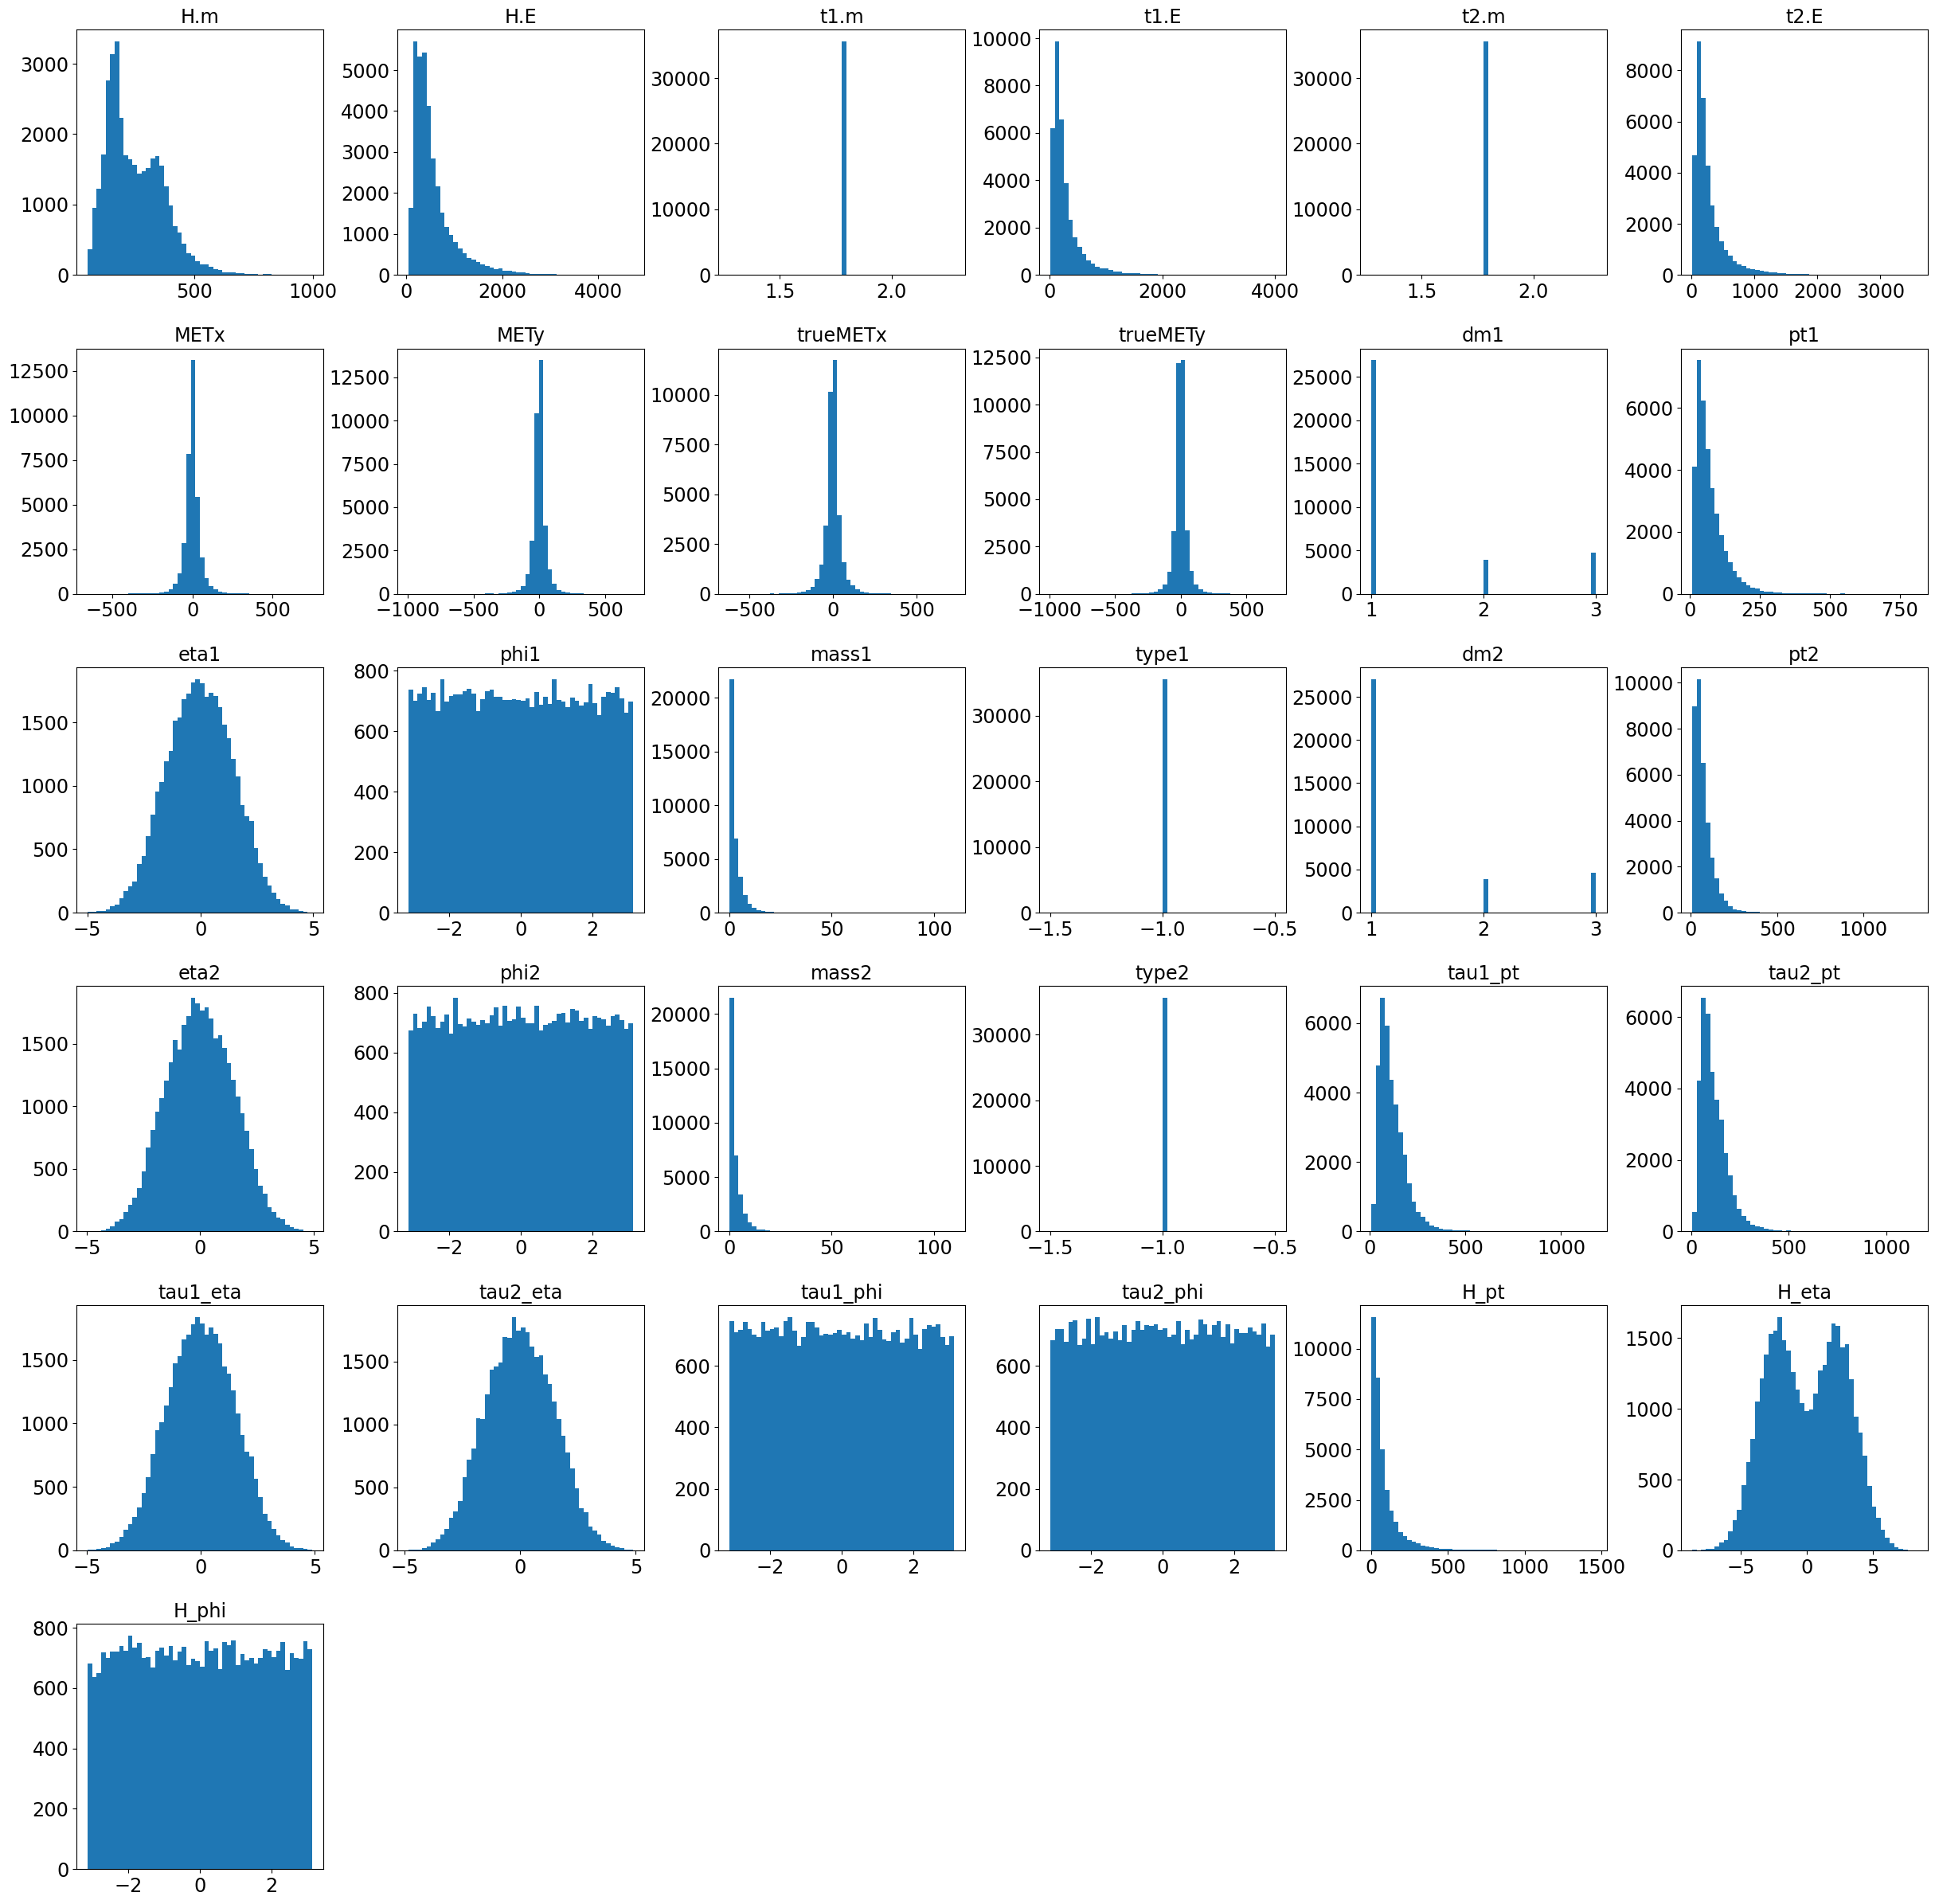

In [11]:
df.hist(figsize=(30, 30), bins=50, grid=False)

### Przydotwanie danych w postaci $\texttt{tf.data.Dataset}$

Na początek przygotujmy funkcje do rozmywania MET-u

In [12]:
def add_smeared_MET(features, label, minval, maxval, mean, stddev, rho_min, rho_max):
    trueMETx = features[:, 10]
    trueMETy = features[:, 11]

    sigma_x = tf.random.uniform(shape=tf.shape(trueMETx), minval=minval, maxval=maxval)
    sigma_y = tf.random.uniform(shape=tf.shape(trueMETy), minval=minval, maxval=maxval)
    rho = tf.random.uniform(shape=tf.shape(trueMETx), minval=rho_min, maxval=rho_max)

    noise_x = tf.random.normal(shape=tf.shape(trueMETx), mean=mean, stddev=stddev)
    noise_y = tf.random.normal(shape=tf.shape(trueMETy), mean=mean, stddev=stddev)

    smeared_METx = trueMETx + sigma_x * noise_x
    smeared_METy = trueMETy + sigma_y * (rho * noise_x + tf.sqrt(1 - tf.square(rho)) * noise_y)

    var_xx = tf.square(sigma_x)
    var_yy = tf.square(sigma_y)
    cov_xy = rho * sigma_x * sigma_y

    # Rozmyte dane jako nowa paczka kolumn
    new_MET_info = tf.stack([smeared_METx, smeared_METy, var_xx, var_yy, cov_xy], axis=1)

    # Doklejamy nowe cechy na koniec, ale nic nie usuwamy
    features_augmented = tf.concat([features, new_MET_info], axis=1)

    return features_augmented, label

Teraz stwórzmy dataset

In [13]:
input_features = [
    'dm1', 'pt1', 'eta1', 'phi1', 'mass1',
    'dm2', 'pt2', 'eta2', 'phi2', 'mass2',
    'trueMETx', 'trueMETy'
]

output_targets = [
    'H.m', 'H_pt', 'H_eta', 'H_phi',
    't1.m', 'tau1_pt', 'tau1_eta', 'tau1_phi',
    't2.m', 'tau2_pt', 'tau2_eta', 'tau2_phi'
]

'''
output_targets = [
    'H.m', 'H.E', 'H_pt', 'H_eta', 'H_phi',
    't1.m', 't1.E', 'tau1_pt', 'tau1_eta', 'tau1_phi',
    't2.m', 't2.E', 'tau2_pt', 'tau2_eta', 'tau2_phi'
]
'''

"\noutput_targets = [\n    'H.m', 'H.E', 'H_pt', 'H_eta', 'H_phi',\n    't1.m', 't1.E', 'tau1_pt', 'tau1_eta', 'tau1_phi',\n    't2.m', 't2.E', 'tau2_pt', 'tau2_eta', 'tau2_phi'\n]\n"

In [14]:
features = df[input_features].astype('float32').values
labels = df[output_targets].astype('float32').values

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

print(colored("Dataset:\n", 'blue'), dataset)
print(colored("Dataset length:\n", 'green'), len(features))

Dataset:
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(12,), dtype=tf.float32, name=None), TensorSpec(shape=(12,), dtype=tf.float32, name=None))>
Dataset length:
 35586


I0000 00:00:1749066541.476393 13206505 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749066541.476417 13206505 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
nStepsPerEpoch = 1024
batchSize = 64

minval = 5.0
maxval = 55.0
mean = 0.0
stddev = 1.0
rho_min = -1.0
rho_max = 1.0

adding_smeard_MET = functools.partial(add_smeared_MET, minval=minval, maxval=maxval, mean=mean, stddev=stddev, rho_min=rho_min, rho_max=rho_max)

dataset_train_preaper = dataset.batch(batchSize).map(adding_smeard_MET).take(nStepsPerEpoch).cache()

item = next(iter(dataset_train_preaper))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (64, 17)
Labels shape: (64, 12)


In [17]:
print("Example features:\n", item[0][:3].numpy())
print("Example labels:\n", item[1][:3].numpy())

Example features:
 [[ 3.00000000e+00  2.26400967e+01  1.49399281e+00 -2.77249002e+00
   1.05658375e-01  1.00000000e+00  8.84766998e+01 -3.60947335e-03
   1.80128157e+00  9.05405104e-01 -5.20731964e+01 -1.32971268e+01
  -7.17809296e+01 -7.96372747e+00  1.66331268e+02  2.25852710e+03
   2.59769653e+02]
 [ 1.00000000e+00  5.33196564e+01  2.07636833e-01 -9.97989118e-01
   7.97627926e-01  3.00000000e+00  1.80683384e+01  9.00008738e-01
  -2.56257147e-01  1.05658375e-01  2.46659973e+02 -1.10700203e+02
   2.39520279e+02 -1.15174515e+02  3.00236320e+01  7.51544495e+01
   3.44812965e+01]
 [ 1.00000000e+00  6.76484680e+01 -2.28251147e+00 -2.55043459e+00
   2.97022200e+00  2.00000000e+00  1.99366226e+02 -7.02415764e-01
   7.78764188e-01  5.10998943e-04  1.43256359e+01  2.12181168e+01
   4.40578270e+01  1.16806517e+01  2.62902173e+03  7.12980774e+02
  -1.30172144e+03]]
Example labels:
 [[ 1.96731995e+02  1.15700005e+02  1.16414106e+00  2.51536155e+00
   1.77681994e+00  7.69537811e+01  1.51970398e+0

Porównanie trueMET i smeared_MET

In [18]:
true_metx_vals = []
smeared_metx_vals = []
true_mety_vals = []
smeared_mety_vals = []

for features, _ in dataset_train_preaper.take(50): 
    true_metx_vals.extend(features[:, 10].numpy())
    smeared_metx_vals.extend(features[:, 12].numpy())
    true_mety_vals.extend(features[:, 11].numpy())
    smeared_mety_vals.extend(features[:, 13].numpy())

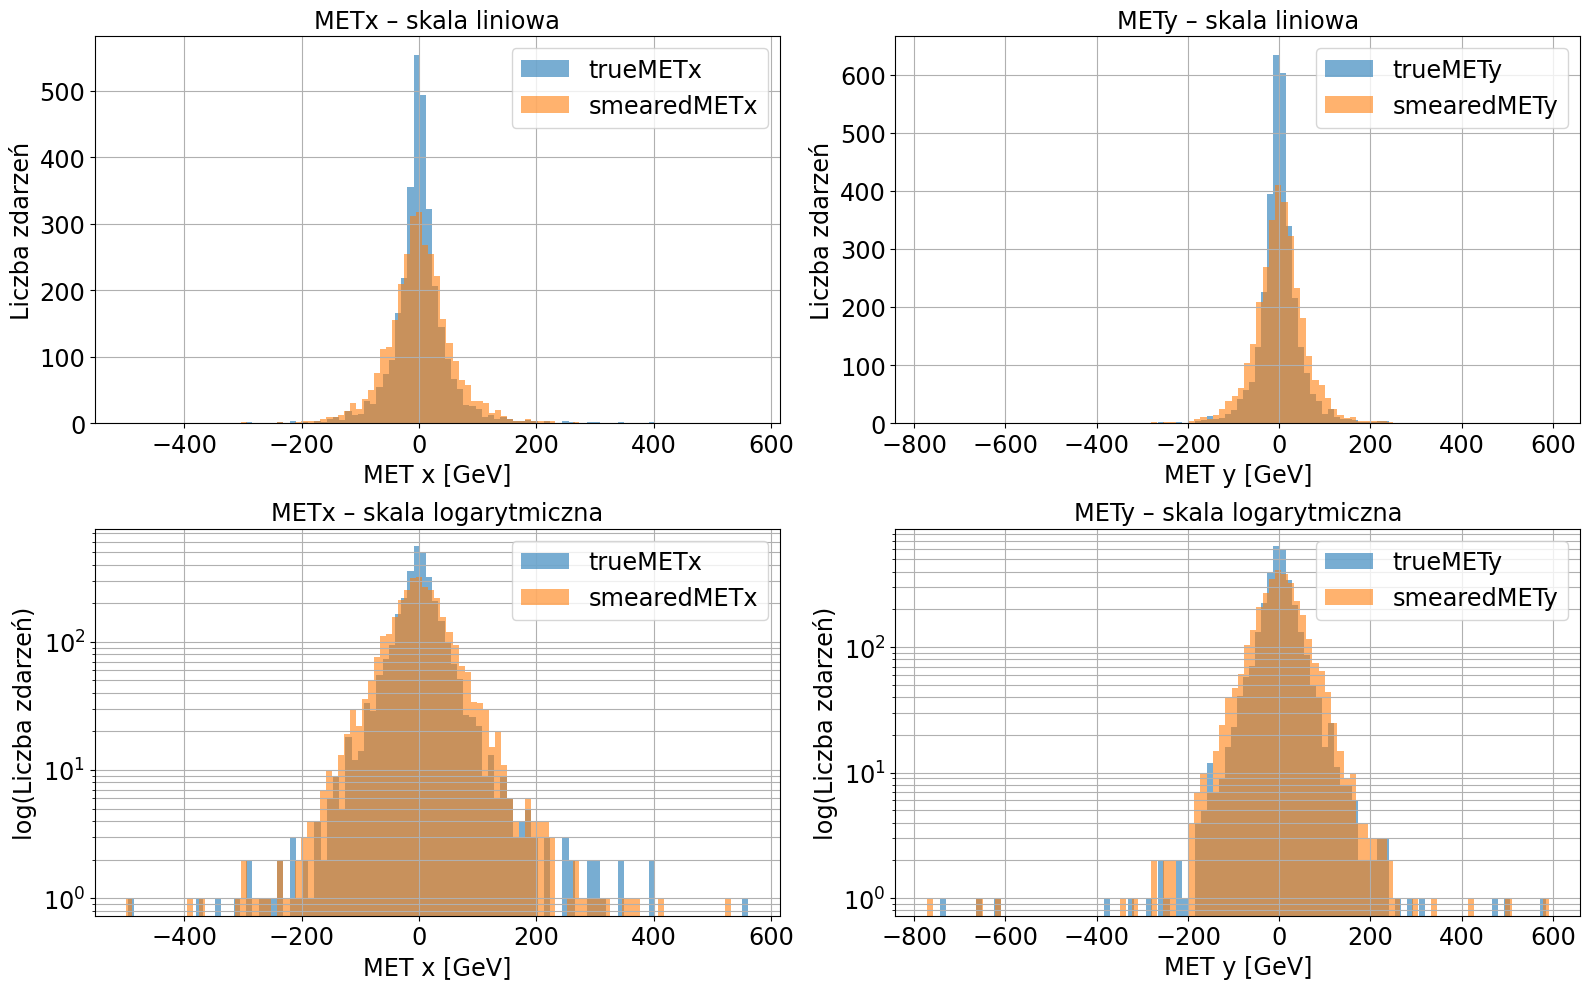

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# METx - skala liniowa
axes[0, 0].hist(true_metx_vals, bins=100, alpha=0.6, label='trueMETx')
axes[0, 0].hist(smeared_metx_vals, bins=100, alpha=0.6, label='smearedMETx')
axes[0, 0].set_title('METx – skala liniowa')
axes[0, 0].set_xlabel('MET x [GeV]')
axes[0, 0].set_ylabel('Liczba zdarzeń')
axes[0, 0].legend()
axes[0, 0].grid(True)

# METy - skala liniowa
axes[0, 1].hist(true_mety_vals, bins=100, alpha=0.6, label='trueMETy')
axes[0, 1].hist(smeared_mety_vals, bins=100, alpha=0.6, label='smearedMETy')
axes[0, 1].set_title('METy – skala liniowa')
axes[0, 1].set_xlabel('MET y [GeV]')
axes[0, 1].set_ylabel('Liczba zdarzeń')
axes[0, 1].legend()
axes[0, 1].grid(True)

# METx - skala logarytmiczna
axes[1, 0].hist(true_metx_vals, bins=100, alpha=0.6, label='trueMETx')
axes[1, 0].hist(smeared_metx_vals, bins=100, alpha=0.6, label='smearedMETx')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('METx – skala logarytmiczna')
axes[1, 0].set_xlabel('MET x [GeV]')
axes[1, 0].set_ylabel('log(Liczba zdarzeń)')
axes[1, 0].legend()
axes[1, 0].grid(True, which='both')

# METy - skala logarytmiczna
axes[1, 1].hist(true_mety_vals, bins=100, alpha=0.6, label='trueMETy')
axes[1, 1].hist(smeared_mety_vals, bins=100, alpha=0.6, label='smearedMETy')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('METy – skala logarytmiczna')
axes[1, 1].set_xlabel('MET y [GeV]')
axes[1, 1].set_ylabel('log(Liczba zdarzeń)')
axes[1, 1].legend()
axes[1, 1].grid(True, which='both')

plt.tight_layout()
plt.show()

Usunięcie trueMETx i trueMETy z danych treningowych

In [20]:
def remove_true_MET(features, label):
    features_cleaned = tf.concat([features[:, :10], features[:, 12:]], axis=1)
    return features_cleaned, label

In [21]:
dataset_train = dataset_train_preaper.map(remove_true_MET).cache()

item = next(iter(dataset_train))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (64, 15)
Labels shape: (64, 12)


### Budoowa modelu i jego trening

Model klasycznej sieci FCNN

In [22]:
model_fc = tf.keras.Sequential(layers=[
    tf.keras.Input(shape=(15,), name="model_input"),
    
    tf.keras.layers.Normalization(),
    
    tf.keras.layers.Dense(64, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),

    tf.keras.layers.Dense(128, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),

    tf.keras.layers.Dense(256, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(512, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(128, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(64, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),
    
    tf.keras.layers.Dense(32, activation='relu',
        bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
        kernel_initializer='he_normal'),

    tf.keras.layers.Dense(12, activation='relu', name="output") 
], name="FC_regression_model")

model_fc.summary()

Model: "FC_regression_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 15)             │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,379 (978.05 KB)

 Trainable params: 250,348 (977.92 KB)

 Non-trainable params: 31 (128.00 B)

In [23]:
def loss_test(y_true, y_pred):
    loss = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)*10      # <- dawało najlepsze efekty póki co to plus mape tez git
    loss += tf.keras.losses.MeanAbsolutePercentageError()(y_true, y_pred)
    #loss += tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return loss

In [24]:
def trainModel(model, nEpochs, train_data, val_data, nStepsPerEpoch=nStepsPerEpoch):
   
    initial_learning_rate = 1E-3
    #loss_fn = loss_test
    loss_fn = tf.keras.losses.Huber(delta=20)
    
      
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*10,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss=loss_fn, metrics=[])
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                           patience=15, verbose=1)
    callbacks = [early_stop_callback]
    #callbacks = []
    
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=nEpochs, 
                        callbacks=callbacks,
                        verbose=1)
    
    plf.plotTrainHistory(history)
    print(colored("Evaluation on training dataset:","blue"))
    model.evaluate(val_data, verbose=1)

Epoch 1/100


E0000 00:00:1749066543.189629 13206505 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


429/429 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 626.9942 - val_loss: 284.1333
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 282.3115 - val_loss: 253.6939
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 265.3633 - val_loss: 259.3813
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 257.3270 - val_loss: 253.3253
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 251.6806 - val_loss: 250.6193
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 248.1464 - val_loss: 250.5705
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 246.4043 - val_loss: 249.3942
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 244.7668 - val_loss: 244.1213
Epoch 9/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 242.2325 - val_loss: 242.8030
Epoch 10/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 241.7840 - val_loss: 240.2088
Epoch 11/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 240.4070 - val_loss: 241.574

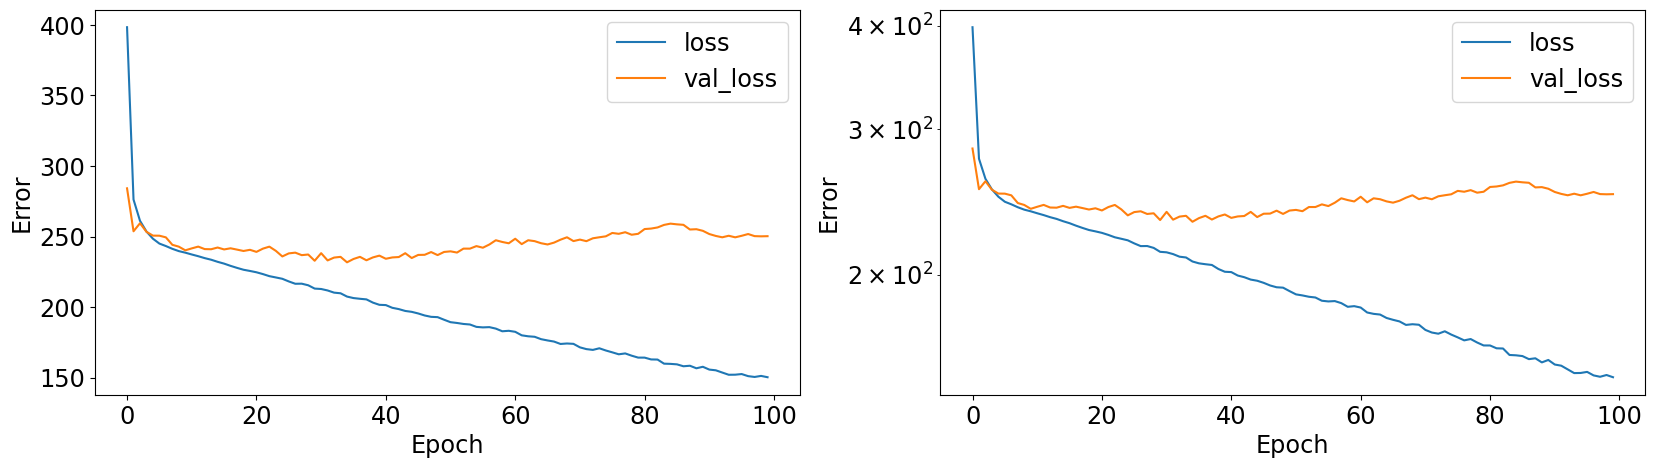

In [25]:
total_dataset = dataset_train.shuffle(2048).cache()
val_batches = total_dataset.take(128)
train_batches = total_dataset.skip(128)

history = trainModel(model_fc, train_data=train_batches, val_data=val_batches, nEpochs=100)

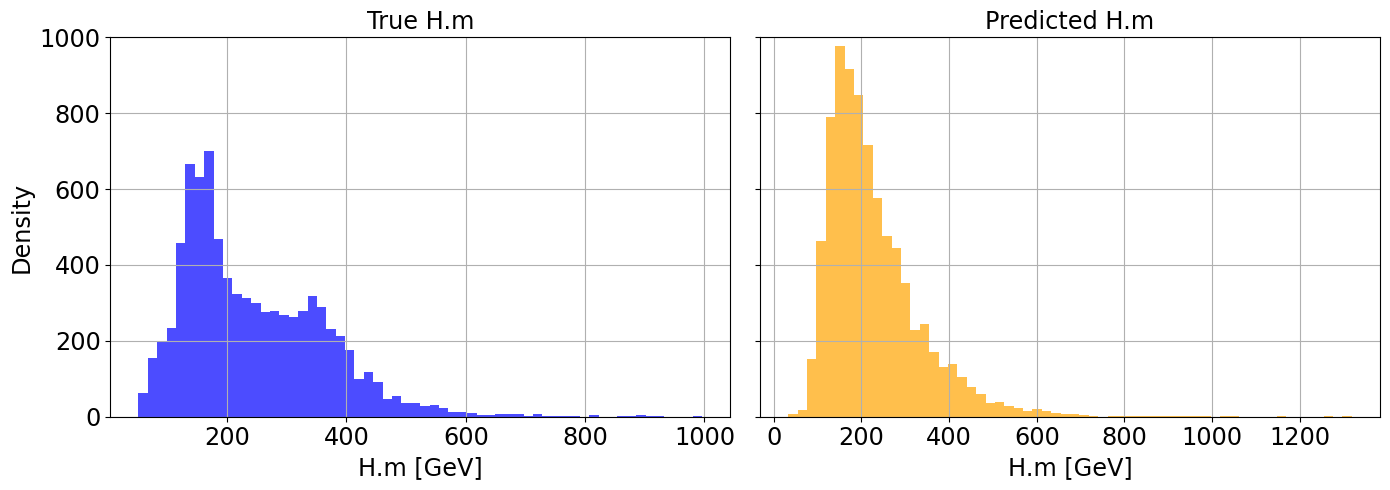

In [26]:
true_H_m = []
pred_H_m = []

#for x_batch, y_batch in train_batches:
for x_batch, y_batch in val_batches:
    predictions = model_fc(x_batch, training=False)
    true_H_m.extend(y_batch[:, 0].numpy())        
    pred_H_m.extend(predictions[:, 0].numpy())



fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Wykres 1: True H.m
axs[0].hist(true_H_m, bins=60, alpha=0.7, color='blue')
axs[0].set_title("True H.m")
axs[0].set_xlabel("H.m [GeV]")
axs[0].set_ylabel("Density")
axs[0].grid(True)
axs[0].set_ylim(0, 1000)

# Wykres 2: Predicted H.m
axs[1].hist(pred_H_m, bins=60, alpha=0.7, color='orange')
axs[1].set_title("Predicted H.m")
axs[1].set_xlabel("H.m [GeV]")
axs[1].grid(True)

plt.tight_layout()
plt.show()

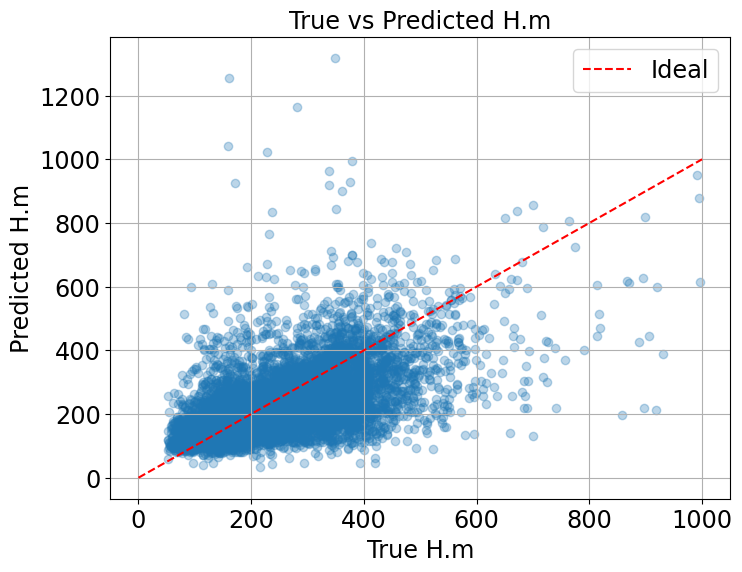

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(true_H_m, pred_H_m, alpha=0.3)
plt.plot([0, 1000], [0, 1000], color='red', linestyle='--', label='Ideal')
plt.xlabel("True H.m")
plt.ylabel("Predicted H.m")
plt.title("True vs Predicted H.m")
plt.legend()
plt.grid(True)
plt.show()

Model architektury dwugałęziowej

In [28]:
def split_inputs(features, labels):
    return {
        'particles_input': features[:10],
        'met_input': features[10:]
    }, labels

In [29]:
dataset_train_test = dataset_train.unbatch()
dataset_split = dataset_train_test.map(split_inputs).batch(batchSize).cache()

total_dataset = dataset_split.shuffle(2048).cache()
val_batches = total_dataset.take(128)
train_batches = total_dataset.skip(128)


In [35]:
input_particles = tf.keras.Input(shape=(10,), name="particles_input")
input_met = tf.keras.Input(shape=(5,), name="met_input")

# Gałąź cząstek
norm_particles = tf.keras.layers.Normalization()(input_particles)
x1 = tf.keras.layers.Dense(64, activation='relu')(norm_particles)
x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
x1 = tf.keras.layers.Dense(256, activation='relu')(x1)

# Gałąź MET
norm_met = tf.keras.layers.Normalization()(input_met)
x2 = tf.keras.layers.Dense(32, activation='relu')(norm_met)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dense(128, activation='relu')(x2)

# Połączenie
x = tf.keras.layers.concatenate([x1, x2])
x = tf.keras.layers.Dense(512, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(256, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(128, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(64, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
output = tf.keras.layers.Dense(12, activation='linear', name='output')(x)

model_dual = tf.keras.Model(inputs={'particles_input': input_particles, 'met_input': input_met}, outputs=output)

model_dual.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ particles_input     │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 10)        │         21 │ particles_input[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 5)         │         11 │ met_input[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │        704 │ normalization_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │        192 │ normalization_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │      8,320 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      2,112 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     33,024 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │      8,320 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ dense_19[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 512)       │    197,120 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │    131,328 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      8,256 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 12)        │        780 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,084 (1.61 MB)

 Trainable params: 423,052 (1.61 MB)

 Non-trainable params: 32 (136.00 B)

In [36]:
def trainModel_dual(model, nEpochs, train_data, val_data, nStepsPerEpoch=512):
   
    initial_learning_rate = 1E-3
    #loss_fn = loss_test
    loss_fn = tf.keras.losses.Huber(delta=20)
    #loss_fn='mse'
    
      
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*10,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss=loss_fn, metrics=[])
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                           patience=15, verbose=1)
    callbacks = [early_stop_callback]
    #callbacks = []
    
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=nEpochs, 
                        callbacks=callbacks,
                        verbose=1);
    
    plf.plotTrainHistory(history)
    print(colored("Evaluation on training dataset:","blue"))
    model.evaluate(val_data, verbose=1)

Epoch 1/300
    428/Unknown 17s 35ms/step - loss: 365.5223

E0000 00:00:1749068446.178777 13206505 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 365.2048 - val_loss: 241.9227
Epoch 2/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 248.9841 - val_loss: 233.9447
Epoch 3/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 238.9186 - val_loss: 228.1699
Epoch 4/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 236.3540 - val_loss: 218.3289
Epoch 5/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 233.9848 - val_loss: 214.1973
Epoch 6/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 231.5510 - val_loss: 212.6879
Epoch 7/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 229.1970 - val_loss: 212.3481
Epoch 8/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 226.7419 - val_loss: 211.6161
Epoch 9/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 224.8866 - val_loss: 210.8090
Epoch 10/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 223.4821 - val_loss: 210.5165
Epoch 11/300
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 221.8948 - val_lo

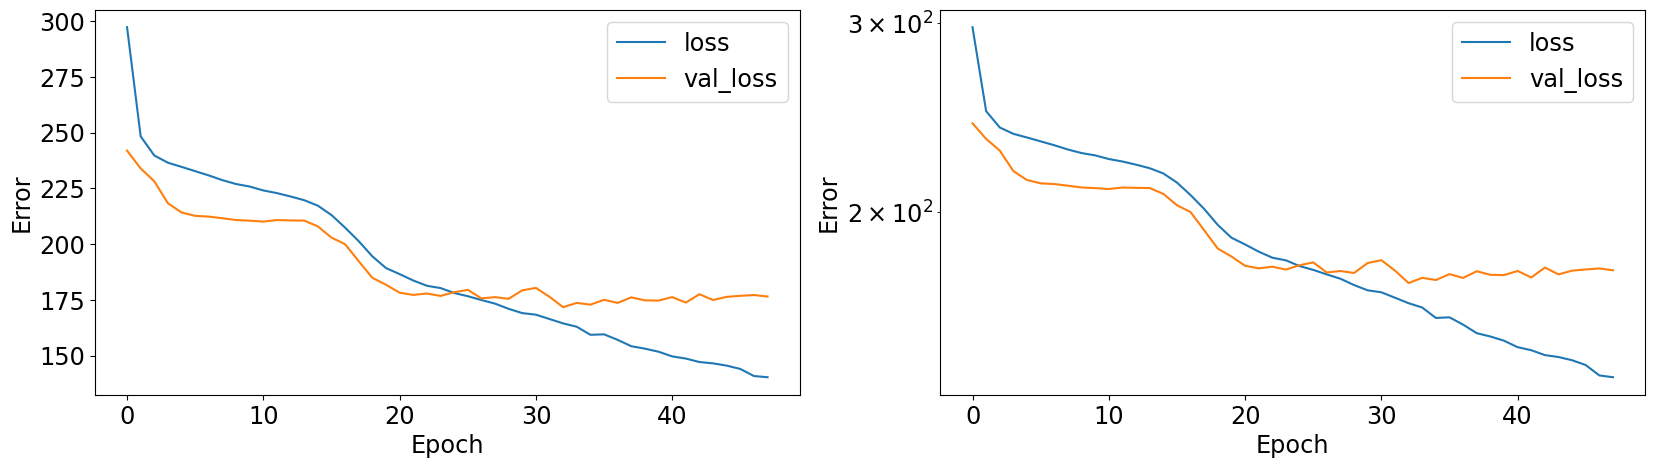

In [37]:
history = trainModel_dual(model_dual, train_data=train_batches, val_data=val_batches, nEpochs=300);

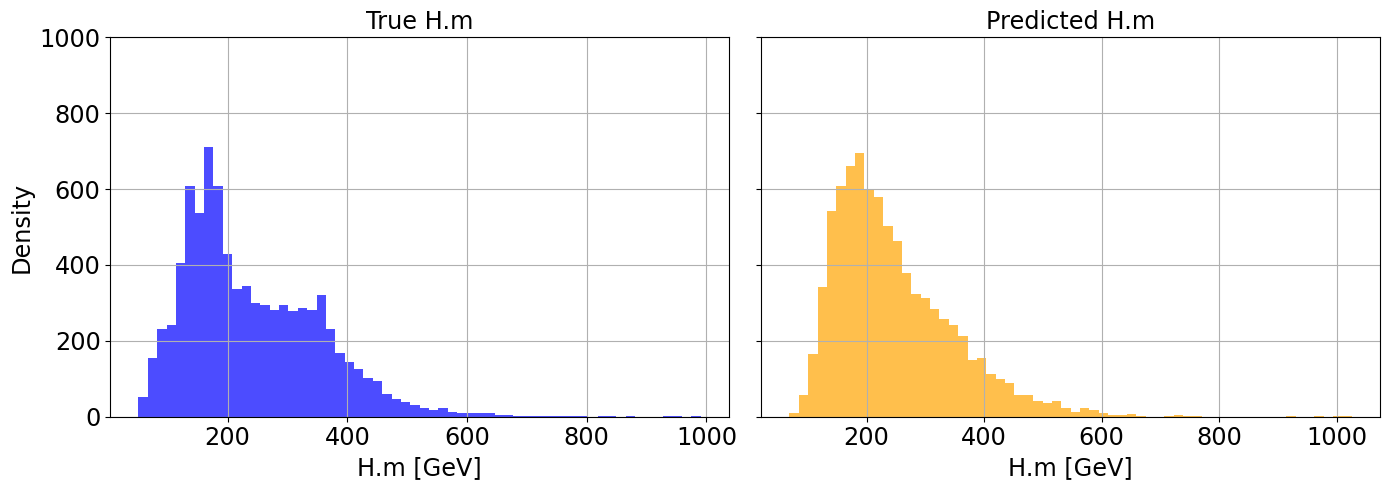

In [38]:
true_H_m = []
pred_H_m = []

#for x_batch, y_batch in train_batches:
for x_batch, y_batch in val_batches:
    predictions = model_dual(x_batch, training=False)
    true_H_m.extend(y_batch[:, 0].numpy())        
    pred_H_m.extend(predictions[:, 0].numpy())



fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Wykres 1: True H.m
axs[0].hist(true_H_m, bins=60, alpha=0.7, color='blue')
axs[0].set_title("True H.m")
axs[0].set_xlabel("H.m [GeV]")
axs[0].set_ylabel("Density")
axs[0].grid(True)
axs[0].set_ylim(0, 1000)

# Wykres 2: Predicted H.m
axs[1].hist(pred_H_m, bins=60, alpha=0.7, color='orange')
axs[1].set_title("Predicted H.m")
axs[1].set_xlabel("H.m [GeV]")
axs[1].grid(True)

plt.tight_layout()
plt.show()

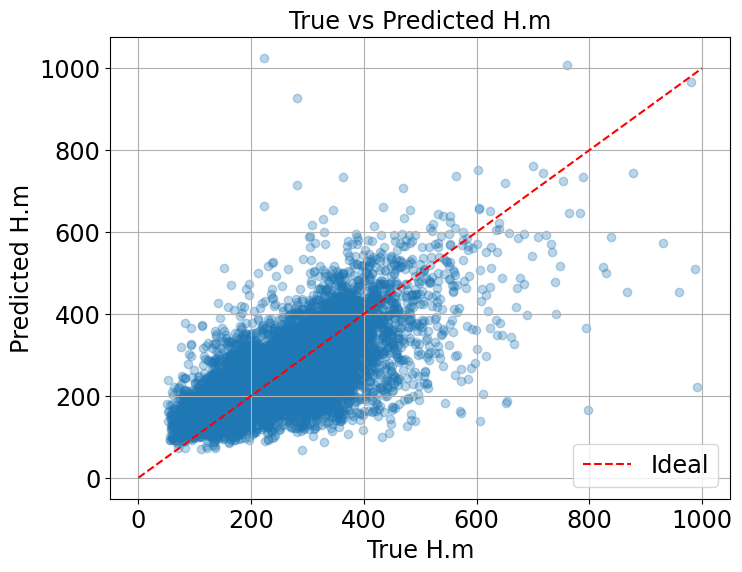

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(true_H_m, pred_H_m, alpha=0.3)
plt.plot([0, 1000], [0, 1000], color='red', linestyle='--', label='Ideal')
plt.xlabel("True H.m")
plt.ylabel("Predicted H.m")
plt.title("True vs Predicted H.m")
plt.legend()
plt.grid(True)
plt.show()

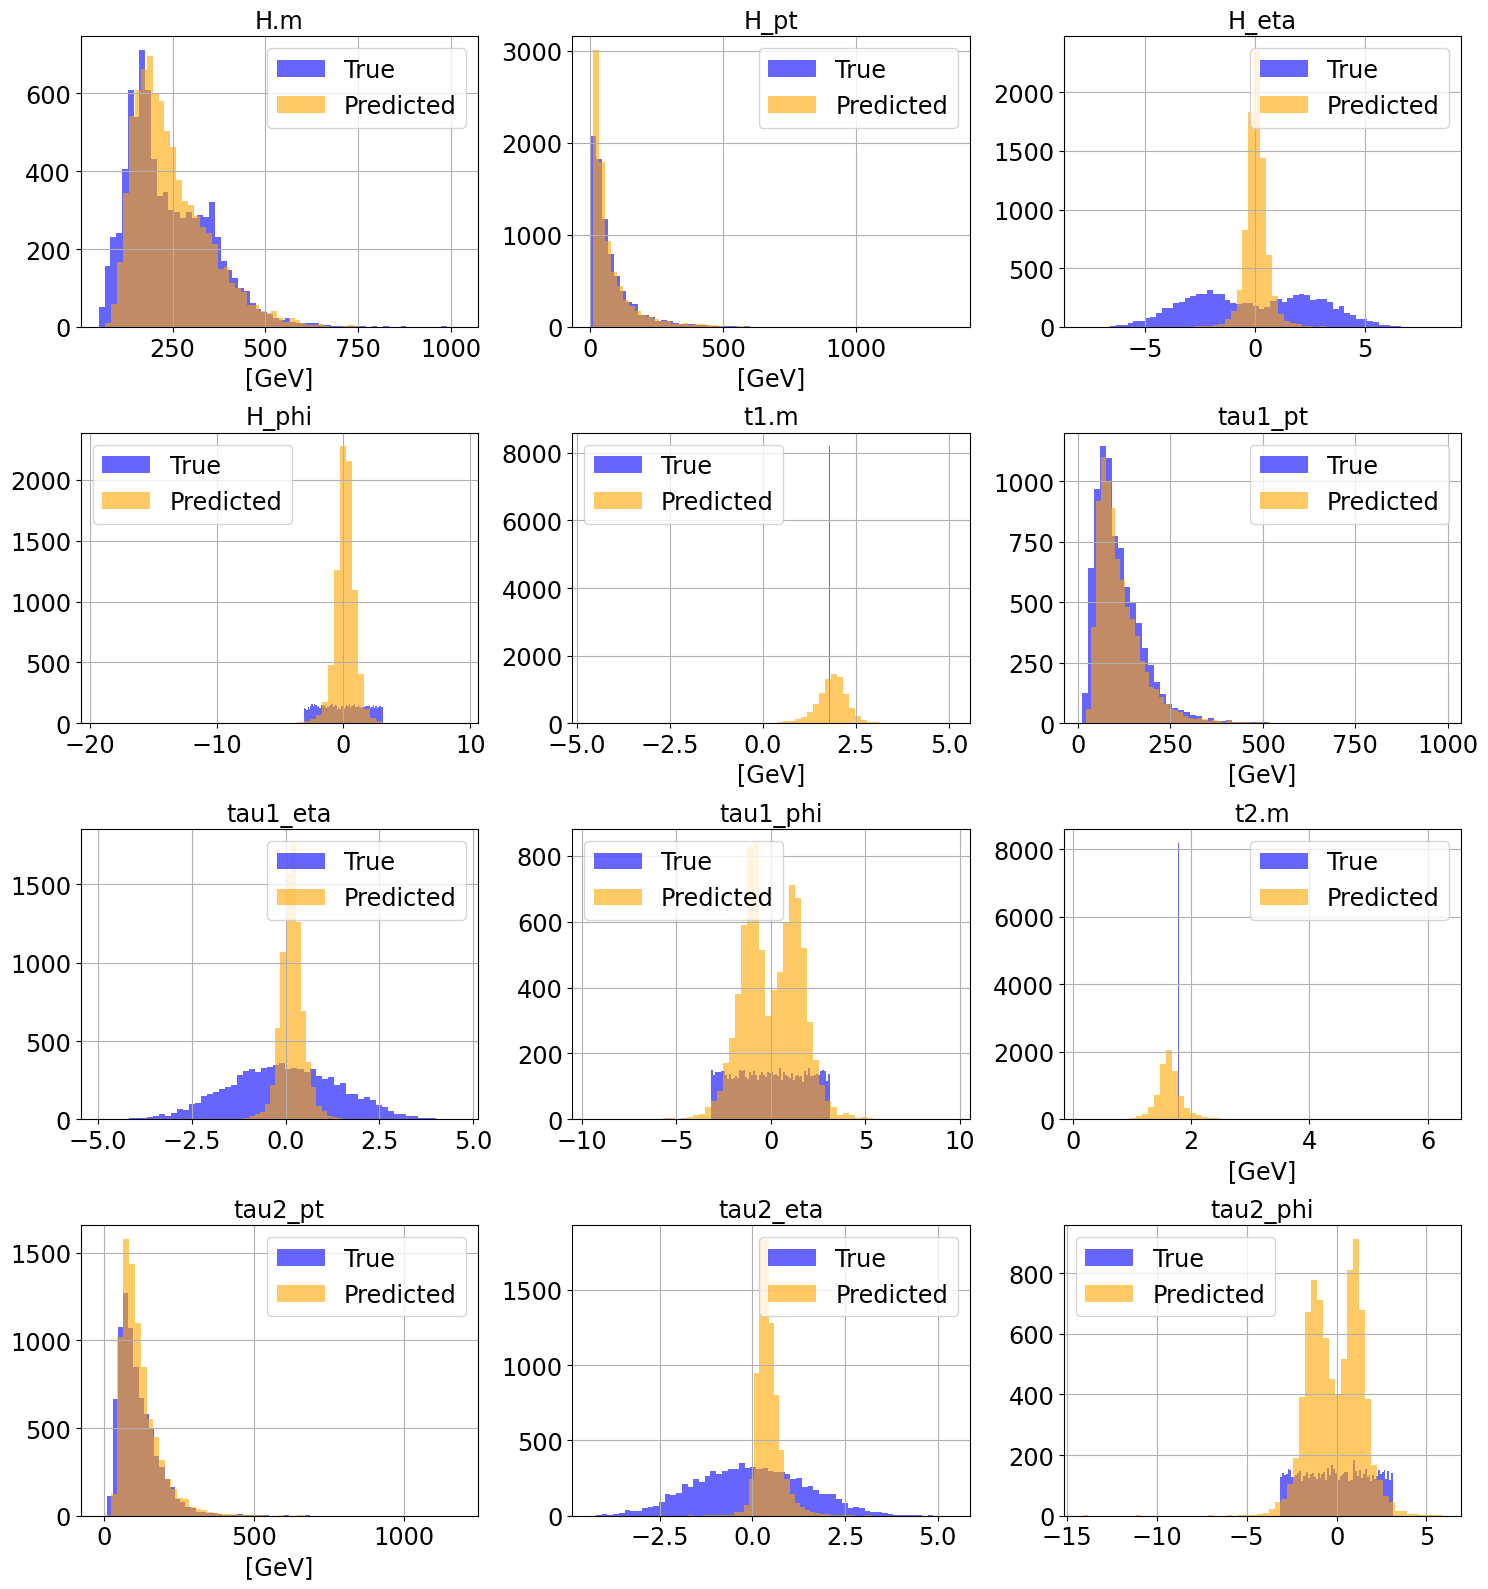

In [40]:
output_names = [
    'H.m', 'H_pt', 'H_eta', 'H_phi',
    't1.m', 'tau1_pt', 'tau1_eta', 'tau1_phi',
    't2.m', 'tau2_pt', 'tau2_eta', 'tau2_phi'
]

true_vals = [[] for _ in range(len(output_names))]
pred_vals = [[] for _ in range(len(output_names))]

# Zbieranie danych
for x_batch, y_batch in val_batches:
    predictions = model_dual(x_batch, training=False)
    for i in range(len(output_names)):
        true_vals[i].extend(y_batch[:, i].numpy())
        pred_vals[i].extend(predictions[:, i].numpy())

# Tworzenie wykresów
n_outputs = len(output_names)
n_cols = 3
n_rows = (n_outputs + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i in range(n_outputs):
    axs[i].hist(true_vals[i], bins=60, alpha=0.6, label='True', color='blue')
    axs[i].hist(pred_vals[i], bins=60, alpha=0.6, label='Predicted', color='orange')
    axs[i].set_title(output_names[i])
    axs[i].set_xlabel('[GeV]' if 'm' in output_names[i] or 'pt' in output_names[i] else '')
    axs[i].grid(True)
    axs[i].legend()

# Ukryj puste subploty jeśli są
for i in range(n_outputs, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [67]:
def split_inputs2(features, labels):
    return {
        'particles_input1': features[:5],
        'particles_input2': features[5:10],
        'met_input': features[10:]
    }, labels

In [68]:
dataset_train_test = dataset_train.unbatch()
dataset_split2 = dataset_train_test.map(split_inputs2).batch(batchSize).cache()

total_dataset = dataset_split2.shuffle(2048).cache()
val_batches = total_dataset.take(128)
train_batches = total_dataset.skip(128)

In [69]:
input_particles1 = tf.keras.Input(shape=(5,), name="particles_input1")
input_particles2 = tf.keras.Input(shape=(5,), name="particles_input2")
input_met = tf.keras.Input(shape=(5,), name="met_input")

# Gałąź cząstek - 1
norm_particles1 = tf.keras.layers.Normalization()(input_particles1)
x1 = tf.keras.layers.Dense(64, activation='relu')(norm_particles1)
x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
x1 = tf.keras.layers.Dense(256, activation='relu')(x1)

# Gałąź cząstek - 2
norm_particles2 = tf.keras.layers.Normalization()(input_particles2)
x2 = tf.keras.layers.Dense(64, activation='relu')(norm_particles2)
x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
x2 = tf.keras.layers.Dense(256, activation='relu')(x2)


#Połączona gałąź cząstek
x12 = tf.keras.layers.concatenate([x1, x2])
x12 = tf.keras.layers.Dense(128, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x12)
x12 = tf.keras.layers.Dense(64, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x12)

# Gałąź MET
norm_met = tf.keras.layers.Normalization()(input_met)
x3 = tf.keras.layers.Dense(32, activation='relu')(norm_met)
x3 = tf.keras.layers.Dense(64, activation='relu')(x3)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)

# Połączenie
x = tf.keras.layers.concatenate([x12, x3])
x = tf.keras.layers.Dense(512, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(256, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(128, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(64, activation='relu',
                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                          kernel_initializer='he_normal')(x)
output = tf.keras.layers.Dense(12, activation='linear', name='output')(x)

model_dual2 = tf.keras.Model(inputs={'particles_input1': input_particles1, 'particles_input2': input_particles2, 'met_input': input_met}, outputs=output)

model_dual2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ particles_input1    │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ particles_input2    │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_20    │ (None, 5)         │         11 │ particles_input1… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_21    │ (None, 5)         │         11 │ particles_input2… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 64)        │        384 │ normalization_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 64)        │        384 │ normalization_21… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 128)       │      8,320 │ dense_102[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 128)       │      8,320 │ dense_105[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 256)       │     33,024 │ dense_103[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 256)       │     33,024 │ dense_106[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_22    │ (None, 5)         │         11 │ met_input[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 512)       │          0 │ dense_104[0][0],  │
│ (Concatenate)       │                   │            │ dense_107[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 32)        │        192 │ normalization_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 128)       │     65,664 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 64)        │      2,112 │ dense_110[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 64)        │      8,256 │ dense_108[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 128)       │      8,320 │ dense_111[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 192)       │          0 │ dense_109[0][0],  │
│ (Concatenate)       │                   │            │ dense_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 512)       │     98,816 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 256)       │    131,328 │ dense_113[0][0] 

 Total params: 440,109 (1.68 MB)

 Trainable params: 440,076 (1.68 MB)

 Non-trainable params: 33 (144.00 B)

In [70]:
def trainModel_dual(model, nEpochs, train_data, val_data, nStepsPerEpoch=512):
   
    initial_learning_rate = 1E-3
    #loss_fn = loss_test
    #loss_fn = tf.keras.losses.Huber(delta=20)
    loss_fn='mse'
    
      
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*10,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss=loss_fn, metrics=[])
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                           patience=15, verbose=1)
    callbacks = [early_stop_callback]
    #callbacks = []
    
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=nEpochs, 
                        callbacks=callbacks,
                        verbose=1);
    
    plf.plotTrainHistory(history)
    print(colored("Evaluation on training dataset:","blue"))
    model.evaluate(val_data, verbose=1)

Epoch 1/100


E0000 00:00:1749070239.829406 13206505 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


    428/Unknown 22s 42ms/step - loss: 3291.0823

/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


429/429 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - loss: 3286.3040 - val_loss: 1691.3687
Epoch 2/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 1640.5718 - val_loss: 1549.1438
Epoch 3/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1544.4594 - val_loss: 1501.5829
Epoch 4/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1508.0543 - val_loss: 1471.6604
Epoch 5/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1478.4937 - val_loss: 1447.8960
Epoch 6/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1457.6819 - val_loss: 1439.2024
Epoch 7/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1436.3328 - val_loss: 1419.4160
Epoch 8/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 1417.3928 - val_loss: 1406.1378
Epoch 9/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1399.1401 - val_loss: 1409.2227
Epoch 10/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1384.4697 - val_loss: 1387.4230
Epoch 11/100
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - los

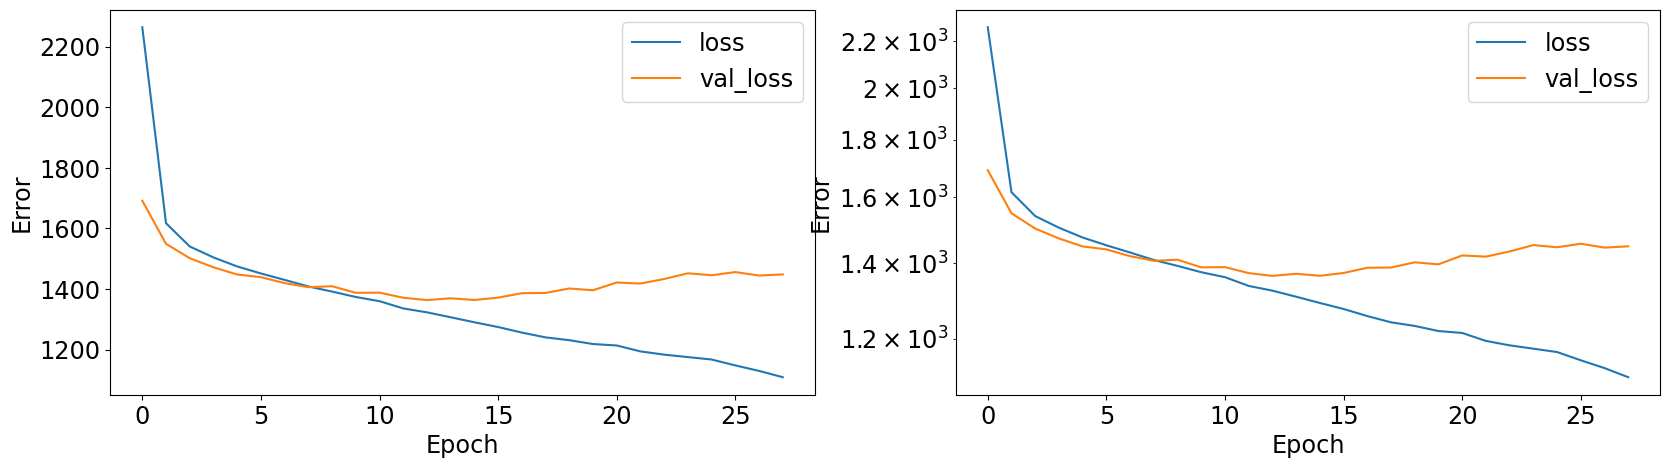

In [71]:
history = trainModel_dual(model_dual2, train_data=train_batches, val_data=val_batches, nEpochs=100);

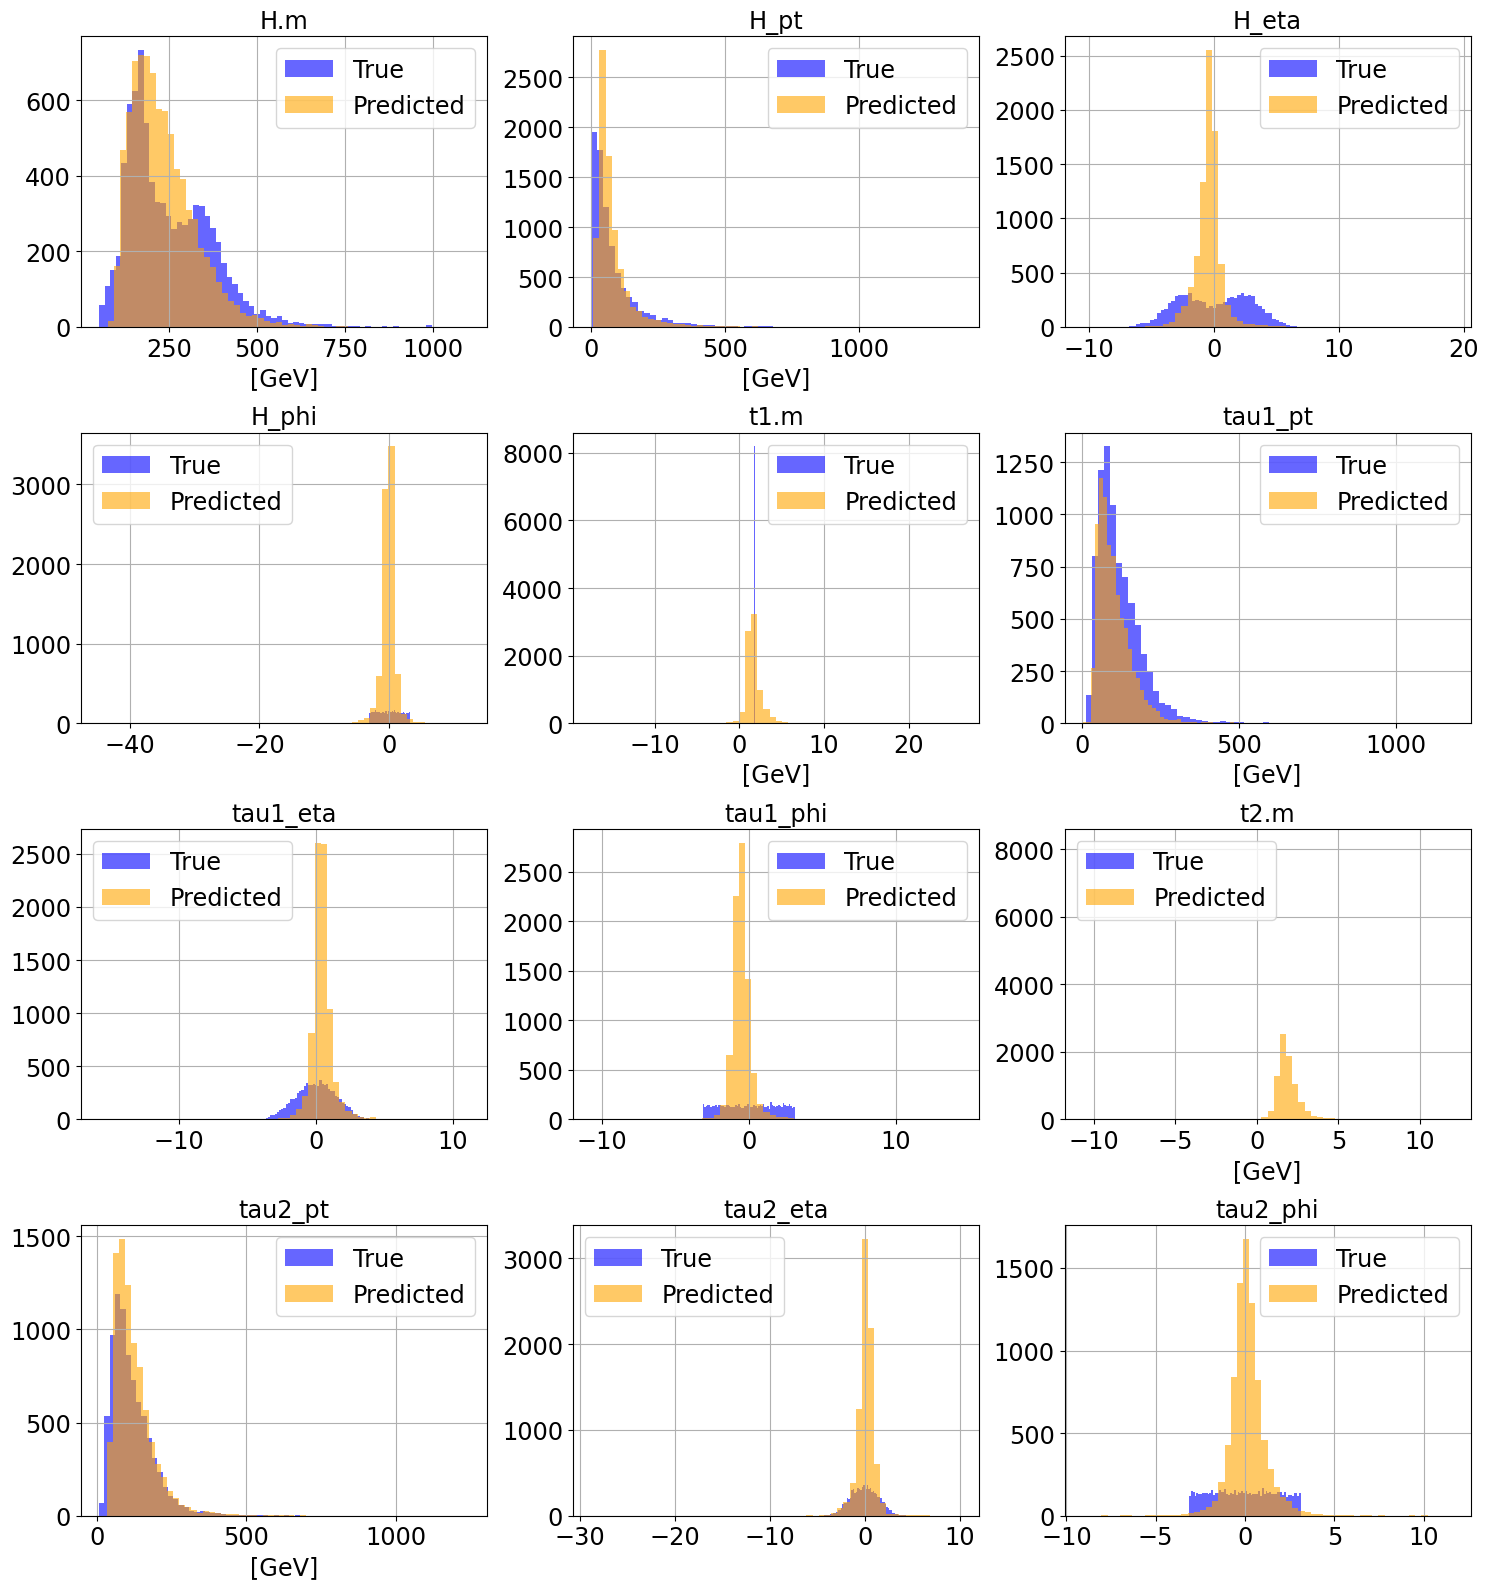

In [72]:
output_names = [
    'H.m', 'H_pt', 'H_eta', 'H_phi',
    't1.m', 'tau1_pt', 'tau1_eta', 'tau1_phi',
    't2.m', 'tau2_pt', 'tau2_eta', 'tau2_phi'
]

true_vals = [[] for _ in range(len(output_names))]
pred_vals = [[] for _ in range(len(output_names))]

# Zbieranie danych
for x_batch, y_batch in val_batches:
    predictions = model_dual2(x_batch, training=False)
    for i in range(len(output_names)):
        true_vals[i].extend(y_batch[:, i].numpy())
        pred_vals[i].extend(predictions[:, i].numpy())

# Tworzenie wykresów
n_outputs = len(output_names)
n_cols = 3
n_rows = (n_outputs + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i in range(n_outputs):
    axs[i].hist(true_vals[i], bins=60, alpha=0.6, label='True', color='blue')
    axs[i].hist(pred_vals[i], bins=60, alpha=0.6, label='Predicted', color='orange')
    axs[i].set_title(output_names[i])
    axs[i].set_xlabel('[GeV]' if 'm' in output_names[i] or 'pt' in output_names[i] else '')
    axs[i].grid(True)
    axs[i].legend()

# Ukryj puste subploty jeśli są
for i in range(n_outputs, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()